In [3]:
import itertools
import os
import numpy as np
import pandas as pd
import pathlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


import torchvision
import torch.utils.data as data
import torchvision.models as models
from torchvision.transforms import v2
from torchvision.io import read_image


import PIL
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import seaborn as sns

import glob

import warnings
warnings.filterwarnings('ignore')

In [4]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

Рассмотрим 2 основных решения ,которые оба дали хороший скор на привате и попали в топ30.
1. Наилучший скор Private Score = 0.00065, Public Score = 0.00076 (Увеличенный датасет)
2. Private Score = 0.0059, Public Score = 0.02049 (только исходный датасет)

В первом случаае, после изучания данных, стало понятен основной домен изображений (люди и собаки), а так же какие модели скорее всего генерировали искусственные картинки. Потому были найдены дополнительные данные ( правила соревнований не запрещали) как сгененированых , так и реальных изображений ( ссылки указаны ниже ).

Так же было попробовано расширить датасет еще больше ( 40К данных) - но результата это не улучшило.Видимо модель уже извлекла все что могда из данных.

Итого итоговый трейновый датасет стал размером 16967 ( с учетом исходных данных). Реальных изображений - 6077, Фейковых - 10890.

In [5]:
# размер валидационной выборки в процентах от изначального датасета
VAL_SIZE = 0

# сделать валидационную выборку сбалансированной по классам
VAL_BALANCED = True

# использовать дополнительные датасеты
EXTEND_DATASETS = True

# efficientnet_v2_m
IMAGE_SIZE = 480
BATCH_SIZE = 11

# efficientnet_v2_s
# IMAGE_SIZE = 384
# BATCH_SIZE = 28

# количество воркеров в лоадерах
NUM_WORKERS = 11

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # если есть gpu, то gpu
#accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [4]:
%%bash

# if data directory doesn not exists, unzip generated-or-not.zip to the current dir
# https://stackoverflow.com/questions/59838/how-do-i-check-if-a-directory-exists-or-not-in-a-bash-shell-script
if [ ! -d "./data" ]; then
  unzip -q './generated-or-not.zip' -d './data'
fi


Все эксперименты проводились с разделением тренировочных данных на train и val выборку. При чем  в val брались данные исключительно из исходного датасета и так чтобы оба класса были сбалансированные( те одинаковое кол-во). Таким образом, на val выборке можно было увидеть какие аугументации лучше работают, какие гиперпарамтеры модели лучше. 
После получения удовлетворительных результатов на val выборке, val выборка обратно возращалась в train и модель обучалась заново и уже результат отправлялся в сабмит. 

In [5]:
# читаем данные в датафрейм
test_df = pd.read_csv('./data/test.csv')
# формируем test_df в нужном нам формате
test_df.insert(loc=1 , column='target', value=0)
for i in test_df.index:
    test_df.id.iloc[i] = (f'./data/images/{test_df.id.iloc[i]}')

# формируем train_df в нужном нам формате
train_df_full = pd.read_csv('./data/train.csv')
for i in train_df_full.index:
    train_df_full.id.iloc[i] = (f'./data/images/{train_df_full.id.iloc[i]}')

# количество классов которые надо предсказывать
CLASSES_NUM = len(train_df_full['target'].value_counts())

if VAL_SIZE:
  if VAL_BALANCED:
    # сколько должно быть данных одного класса
    samples_count = int(len(train_df_full) * VAL_SIZE // CLASSES_NUM)
    train_df_full_shuffle = shuffle(train_df_full, random_state=42)


    a = train_df_full_shuffle[train_df_full_shuffle['target']==0].iloc[:samples_count+1]  
    b = train_df_full_shuffle[train_df_full_shuffle['target']==1].iloc[:samples_count+1] 
    val_indexes = a.index.append(b.index)

    val_df =  pd.concat([a, b], ignore_index=True)
   
    # все остальное сохраняем в трейновый датасет
    train_df = train_df_full.drop(val_indexes, axis=0, inplace=False)
    # train_df = train_df_full_shuffle.loc[~train_df_full_shuffle.index.isin(val_indexes)]

  else: 
    # когда сбалансированная выборка не нужна, можем использовать просто train_test_split
    train_df, val_df = train_test_split(train_df_full, test_size=0.2, random_state=42, stratify=train_df_full["target"])
else:
  train_df = train_df_full
  val_df = None

In [6]:
if val_df is not None:
    print(val_df['target'].value_counts())
else:
    print(train_df['target'].value_counts())

target
0    667
1    345
Name: count, dtype: int64


EDA данных

In [6]:
train_df_full.head(10)

,id,target
0,./data/images/gL5fWrgNPU.jpg,0
1,./data/images/KKWXJDN8uM.png,1
2,./data/images/Wb2I0CXlAY.jpg,0
3,./data/images/G7PLhKpaf7.jpeg,1
4,./data/images/DEUkeefz6Z.jpg,0
5,./data/images/enth8MGCce.jpg,0
6,./data/images/hG9nlBfDeh,1
7,./data/images/Re69C5wIs7.jpg,0
8,./data/images/fsCx46u0Bq.jpg,0
9,./data/images/yEi4q3wAJS.jpg,0


1. Выведем сколько данных каждого класса

<Axes: xlabel='target', ylabel='count'>

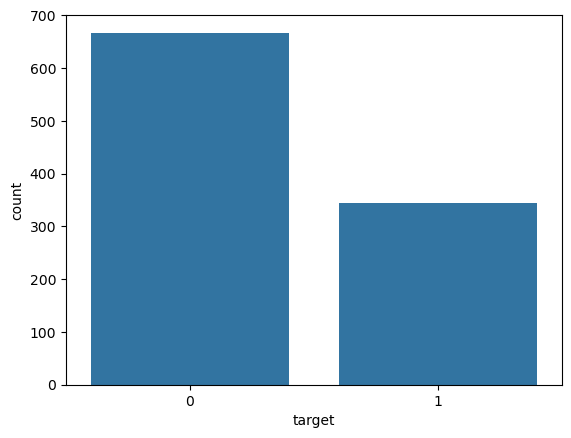

In [7]:
sns.countplot(x = 'target', data = train_df_full)

Видим, что количество данных по классам не одинаково. Пока только запомним это (но скорее всего нужно будет добавить данных 1 класса)

2. Посмотрим, как распределены размеры изображений на трейн и тест выборках

In [133]:
image_dimensions_train = []

for  i, img_path in enumerate(train_df_full.id):
    try:
        image_dimensions_train.append([Image.open(img_path).size, train_df_full.target[i]])
    except FileNotFoundError:
        all_possible_images = glob.glob(f'{img_path}.*')
        if len(all_possible_images) == 1:
            image_dimensions_train.append([Image.open(all_possible_images[0]).size, train_df_full.target[i]])


image_dimensions_test = []

for  i, img_path in enumerate(test_df.id):
    try:
        image_dimensions_test.append([Image.open(img_path).size, test_df.target[i]])
    except FileNotFoundError:
        all_possible_images = glob.glob(f'{img_path}.*')
        if len(all_possible_images) == 1:
            image_dimensions_test.append([Image.open(all_possible_images[0]).size, test_df.target[i]])

print(len(image_dimensions_train) )          
len(image_dimensions_test)

1012


506

In [134]:
size_train, target_train = zip(*image_dimensions_train)
widths_train, heights_train = zip(*size_train)

size_test, target_test = zip(* image_dimensions_test)
widths_test, heights_test = zip(*size_test)

In [136]:
dimensions_train = []
dimensions_train.append(list(widths_train))
dimensions_train.append(list(heights_train))
dimensions_train.append(list(target_train))
dimensions_train_df = pd.DataFrame(dimensions_train). transpose ()
dimensions_train_df.columns = ['widths_train','heights_train','target_train']
dimensions_train_df

,widths_train,heights_train,target_train
0,500,375,0
1,512,512,1
2,375,500,0
3,1024,1024,1
4,500,375,0
...,...,...,...
1007,738,734,1
1008,500,375,0
1009,357,500,0
1010,500,330,0


In [137]:
dimensions_test = []
dimensions_test.append(list(widths_test))
dimensions_test.append(list(heights_test))
dimensions_test.append(list(target_test))
dimensions_test_df = pd.DataFrame(dimensions_test). transpose ()
dimensions_test_df.columns = ['widths_test','heights_test','target_test']
dimensions_test_df

,widths_test,heights_test,target_test
0,500,388,0
1,400,500,0
2,500,334,0
3,1024,1024,0
4,375,500,0
...,...,...,...
501,722,730,0
502,500,333,0
503,500,375,0
504,668,669,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Distribution of Image Size train_data')

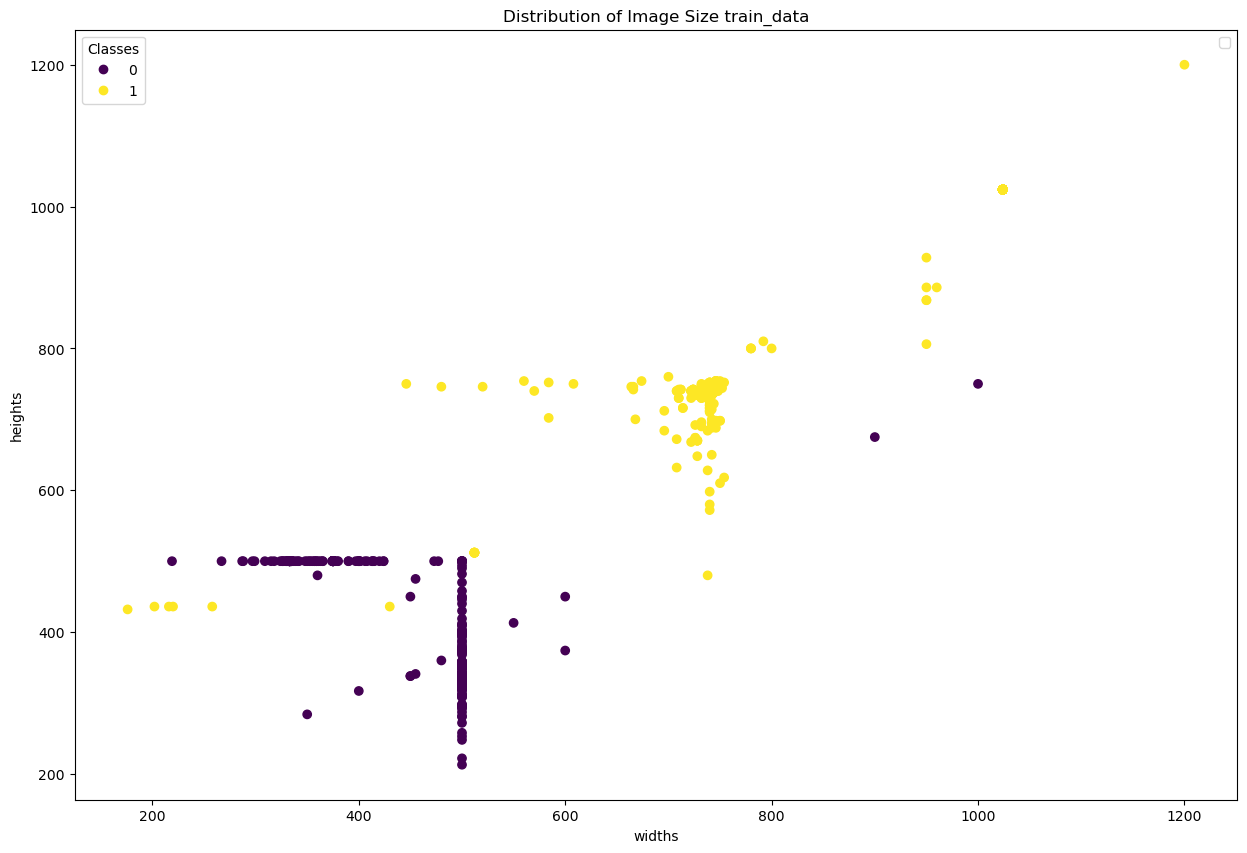

In [141]:
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(dimensions_train_df['widths_train'], dimensions_train_df['heights_train'], alpha=1,
            c = dimensions_train_df.target_train)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)
plt.xlabel('widths')
plt.ylabel('heights')
ax.legend()
ax.set_title('Distribution of Image Size train_data')

Text(0.5, 1.0, 'Distribution of Image Size test_data')

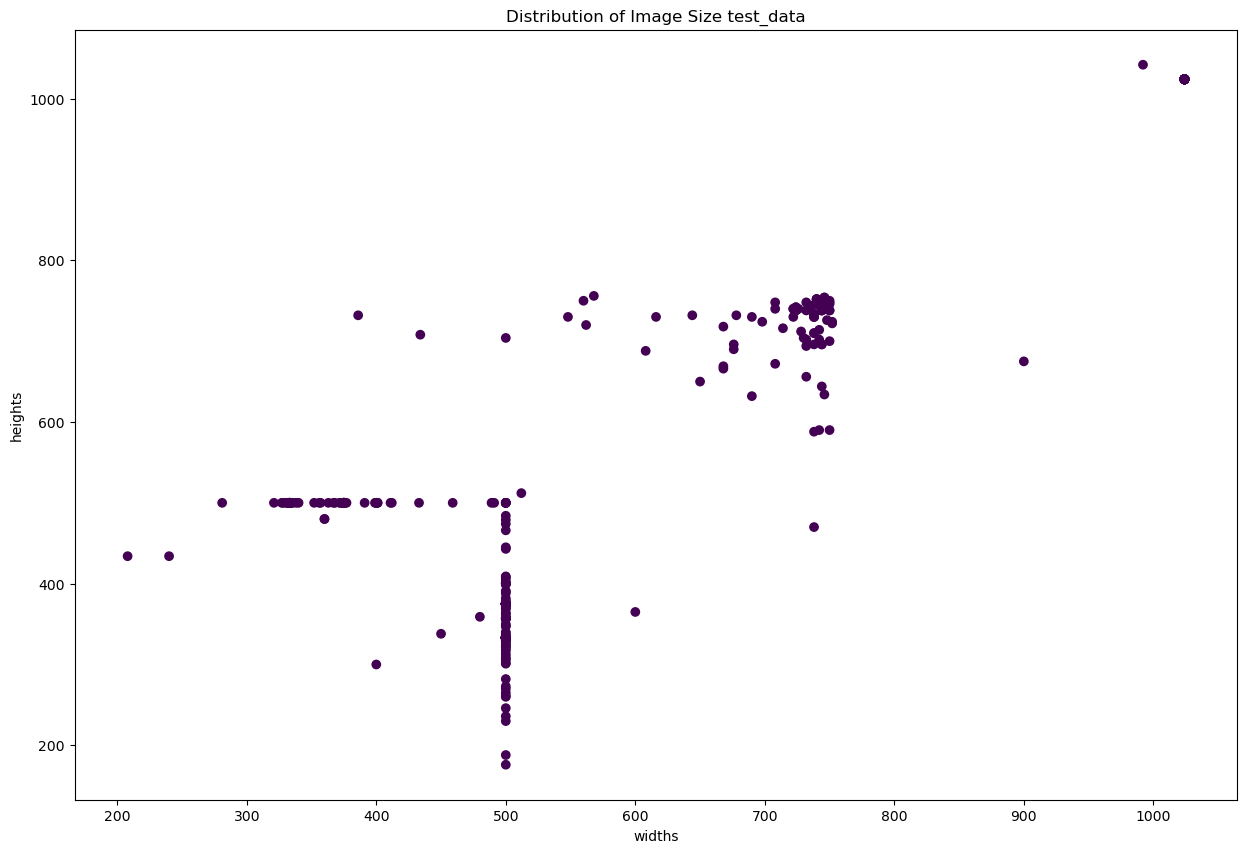

In [145]:
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(dimensions_test_df['widths_test'], dimensions_test_df['heights_test'], alpha=1,
            c = dimensions_test_df.target_test)
plt.xlabel('widths')
plt.ylabel('heights')
ax.set_title('Distribution of Image Size test_data')

По итогу на трейне можно увидеть что сгенерированные картинки в большинстве своем в большем размере,чем реальные и  квадратные.

Можно подумать, что и в тесте будет такое же распредление размеров. Но нельзя на такое полагаться, тк на самом деле картинки обоих классов могут прийти разных размеров и такая фича совсем не достоверна. так же есть все же некотрые выбросы- что как раз может попасть в приват сабмит.

Построим еще графики распредления в виде гистограмм просто для понимания а какие размеры картинок есть в данных и как они распределены

Text(0, 0.5, 'Number of Images')

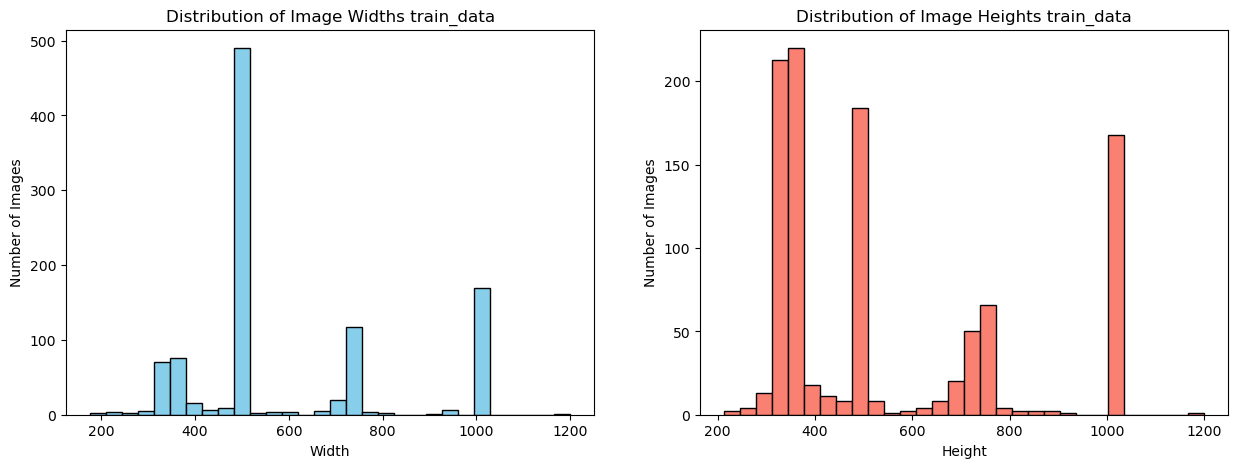

In [162]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting widths
ax[0].hist(dimensions_train_df['widths_train'], bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Distribution of Image Widths train_data')

ax[0].set_xlabel('Width')
ax[0].set_ylabel('Number of Images')

# Plotting heights
ax[1].hist(dimensions_train_df['heights_train'], bins=30, color='salmon', edgecolor='black')
ax[1].set_title('Distribution of Image Heights train_data')
ax[1].set_xlabel('Height')
ax[1].set_ylabel('Number of Images')

Text(0, 0.5, 'Number of Images')

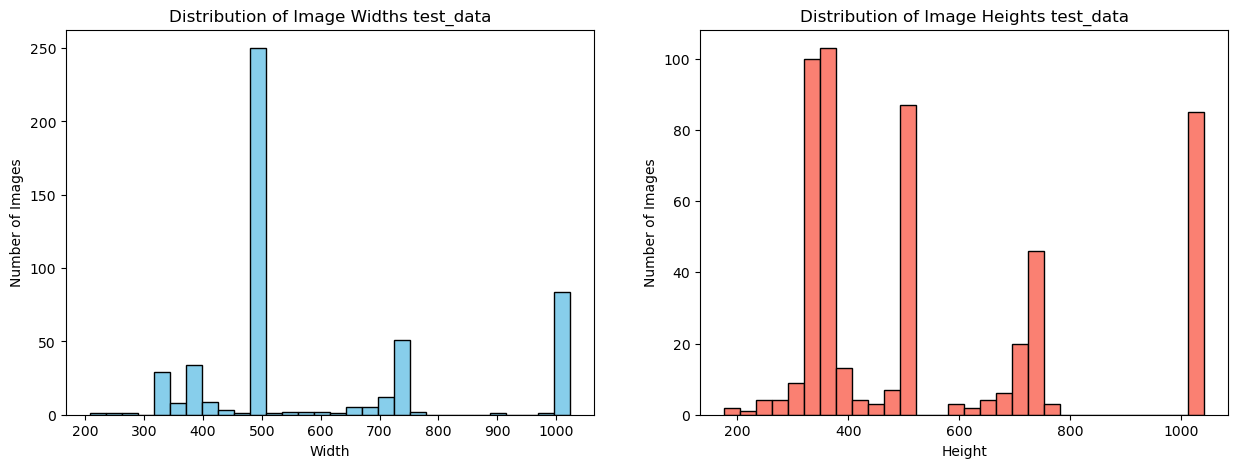

In [163]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting widths
ax[0].hist(dimensions_test_df['widths_test'], bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Distribution of Image Widths test_data')

ax[0].set_xlabel('Width')
ax[0].set_ylabel('Number of Images')

# Plotting heights
ax[1].hist(dimensions_test_df['heights_test'], bins=30, color='salmon', edgecolor='black')
ax[1].set_title('Distribution of Image Heights test_data')
ax[1].set_xlabel('Height')
ax[1].set_ylabel('Number of Images')

Добавление в train dataset дополнительных данных

In [164]:
# https://huggingface.co/datasets/InfImagine/FakeImageDataset/tree/main/ImageData/val
# https://huggingface.co/datasets/Bingsu/Human_Action_Recognition
# https://www.kaggle.com/datasets/meetnagadia/human-action-recognition-har-dataset

# You can use following codes to extract the files in each subfolder (take the IF-CC95K subfolder in ImageData/val/IF-CC95K as an example)：
# 
# cat IF-CC95K.tar.gz.* > IF-CC95K.tar.gz
# tar -xvf IF-CC95K.tar.gz

if EXTEND_DATASETS:
    # расширяем трейновы датасет
    # данные в формате ('путь для поиска файлов', таргет)
    image_dirs = (
        ('./data_1/stylegan3_1024x1024/*.png', 1),
        ('./data_1/SDv15R-dpmsolver-25-15K/*.png', 1),
        ('./data_1/real_person_test/*.jpg', 0),

        # ('./data_1/real_person_train/*.jpg', 0),
        # ('./data_2/stylegan3-t-ffhqu-1024x1024/*.png', 1),
        # ('./data_2/SDv15R-dpmsolver-25-15K/*.png', 1),
        # ('./data_2/SDv15-dpmsolver-25-15K/*.png', 1),
    )
    new_data = []
    for image_dir, target in image_dirs:
        new_data += zip(glob.glob(image_dir), itertools.repeat(target))
    new_data_df = pd.DataFrame(new_data, columns =['id', 'target'])
    full_df = pd.concat([train_df, new_data_df], ignore_index=True)
else:
    full_df = train_df
full_df

,id,target
0,./data/images/gL5fWrgNPU.jpg,0
1,./data/images/KKWXJDN8uM.png,1
2,./data/images/Wb2I0CXlAY.jpg,0
3,./data/images/G7PLhKpaf7.jpeg,1
4,./data/images/DEUkeefz6Z.jpg,0
...,...,...
16962,./data_1/real_person_test/Image_2391.jpg,0
16963,./data_1/real_person_test/Image_727.jpg,0
16964,./data_1/real_person_test/Image_3373.jpg,0
16965,./data_1/real_person_test/Image_3271.jpg,0


In [8]:
# некотоыре картинки в датасетах могут быть повреждены и не читаться
# находим их и удаляем руками

# from tqdm.notebook import tqdm

# for _, item in tqdm(full_df.iterrows()):
#     img_path = item['id']
#     try:
#         image = Image.open(img_path).convert('RGB')
#     except FileNotFoundError:
#         all_possible_images = glob.glob(f'{img_path}.*')
#         if len(all_possible_images) == 1:
#             image = Image.open(all_possible_images[0]).convert('RGB')
#         else:
#             print(img_path)
#             raise
#     except Exception as e:
#         print(img_path, str(e))

In [165]:
full_df.value_counts('target')

target
1    10890
0     6077
Name: count, dtype: int64

Формируем ImagesDataset

In [10]:
import functools

class ImagesDataset(data.Dataset):
  def __init__(self, img_labels_df = None, transform = None, target_transform = None):
      self.img_labels_df = img_labels_df
      self.transform = transform
      self.target_transform = target_transform

  @functools.cache  
  # https://docs.python.org/3/library/functools.html#functools.cache
  def __getitem__(self, idx):
    img_path = self.img_labels_df.iloc[idx, 0]
    # image = read_image(img_path)
    label = self.img_labels_df.iloc[idx, 1]

    # Сразу используем PIL тк torchvision.transforms работает с PIL Image
    try:
        image = Image.open(img_path).convert('RGB')
    except FileNotFoundError:
        all_possible_images = glob.glob(f'{img_path}.*')
        if len(all_possible_images) == 1:
            image = Image.open(all_possible_images[0]).convert('RGB')
        else:
            raise

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)

    return image, label

  def __len__(self):
        return len(self.img_labels_df)

Применяем аугументации. 

Были проведены эксперименты с различными аугуметациями( оставила закоментированными) в том числе cutmix и mixup. 
Но как показали эксперименты на val выборке не сильно менялся скор при добавлении цветовых, контраста аугов и гаусовского размытия. 

Хороший результат показал RandomHorizontalFlip и RandomRotation( что кажется логичным - в модель вносится разнообразие данных, но те фичи в изображениях которые важны для классфикации изображения остаются ( кривые руки , неправильной формы лицо , цветовая палитра каналов у реальных и фейковых изображений))

In [11]:
p = 0.2
data_transforms = {
    'train': v2.Compose([
        v2.ToImage(), # Convert to tensor, only needed if you had a PIL image
        v2.ToDtype(torch.uint8, scale=True),# optional, most input are already uint8 at this point
        v2.Resize(IMAGE_SIZE),
        v2.RandomCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
        # v2.RandomVerticalFlip(p=0.5),
        # v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
        # v2.Grayscale(),
        # v2.RandomAdjustSharpness(sharpness_factor=2),
        # v2.RandomAutocontrast(),
        # v2.RandomEqualize(p=p),
        
        # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        # v2.RandomSolarize(threshold=192.0, p=0.7),
        # v2.ColorJitter(brightness=.5, hue=.3),
        # v2.RandomRotation(degrees=(0, 180)),

        # https://pytorch.org/vision/main/generated/torchvision.transforms.v2.RandomApply.html#randomapply
        v2.RandomApply(torch.nn.ModuleList([
            v2.RandomRotation(degrees=(0, 180)),
        ]), p=p),

        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        #v2.RandomErasing(0.2)
     ]),
    'test': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.Resize(IMAGE_SIZE),
        v2.CenterCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [12]:
# from torch.utils.data import default_collate

# CLASSES_NUM = len(train_df['target'].value_counts())

# cutmix = v2.CutMix(num_classes=CLASSES_NUM)
# mixup = v2.MixUp(num_classes=CLASSES_NUM)
# cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

# def collate_fn(batch):
#     return cutmix_or_mixup(*default_collate(batch))

Формирование датасетов 

In [13]:
train_dataset = ImagesDataset(
    img_labels_df=full_df,
    transform=data_transforms['train']
)

if val_df is not None:
    val_dataset = ImagesDataset(
        img_labels_df=val_df,
        transform=data_transforms['test']
    )
else:
    val_dataset = None

test_dataset = ImagesDataset(
    img_labels_df=test_df,
    transform=data_transforms['test']
)

# def collate_fn(batch):
#     data = [item[0] for item in batch]
#     target = [item[1] for item in batch]
#     return [data, target]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True) if val_dataset else None

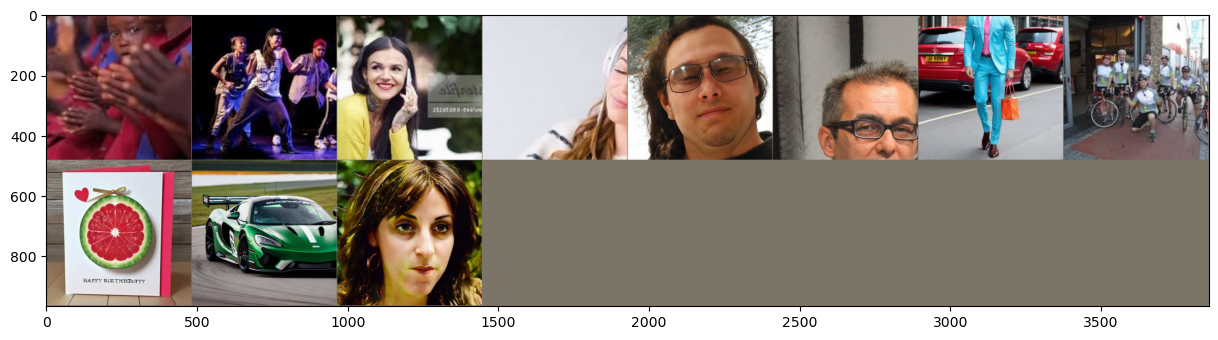

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(train_loader))
# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out)

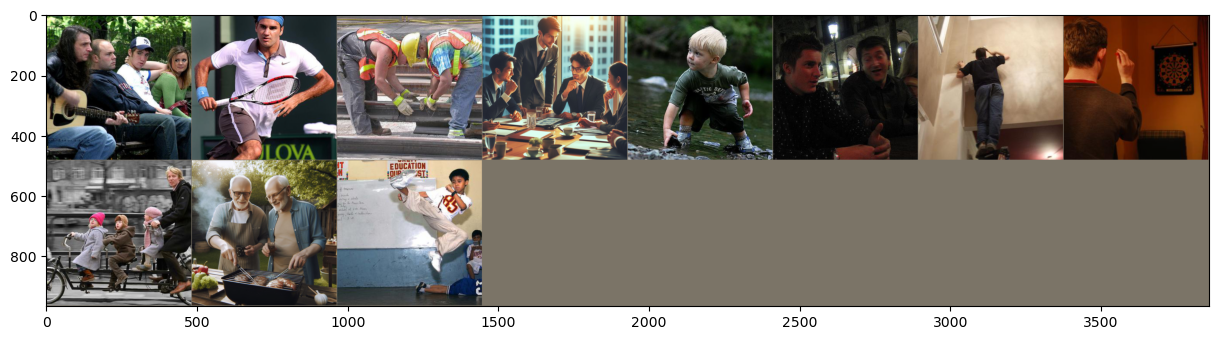

torch.Size([11, 3, 480, 480]) torch.Size([11]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [15]:
inputs, classes = next(iter(test_loader))
# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out)
print(inputs.shape, classes.shape ,classes)

# **Возьмем efficientnet_v2_m в качестве классификатора**

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, val_losses, train_accuracies, val_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='val')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

Обучение модели

In [17]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # labels from catmix
        if len(labels.shape) == 2:
          labels_for_accuracy = labels.argmax(dim=1)
        else:
          labels_for_accuracy = labels

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels_for_accuracy).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy

@torch.no_grad()
def validation_epoch(model, criterion, val_loader, tqdm_desc):
    val_loss, val_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(val_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        # labels from catmix
        # if len(labels.shape) == 2:
        #   labels = labels.argmax(dim=1)

        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        val_loss += loss.item() * images.shape[0]
        val_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    return val_loss, val_accuracy

# @torch.no_grad()
# def model_inference(model, test_loader):
#     model.eval()
#     predictions = []
#     for images, _ in tqdm(test_loader, desc='Predictions'):
#         images = images.to(device)
#         logits = model(images)
#         # predictions += logits.argmax(dim=1).to('cpu').numpy().tolist()
#         predictions += torch.round(torch.sigmoid(logits.max(dim=1).to('cpu').numpy().tolist()))
#     return predictions

@torch.no_grad()
def model_inference(model, test_loader):
    model.eval()
    predictions_class = []
    predictions_prob = []
    logit = []
    for images, _ in tqdm(test_loader, desc='Predictions'):
        images = images.to(device)
        logits = model(images)
        logit+= logits

        predictions_class += logits.argmax(dim=1).to('cpu').numpy().tolist()

        temp = [x[1] for x in logits]
        predictions_prob += [torch.round(torch.sigmoid(x), decimals=6).to('cpu').numpy().tolist() for x in temp]
        # predictions_prob += torch.round(torch.sigmoid(torch.max(logits,dim=1)))
    return predictions_class, predictions_prob, logit, logits

def train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        if val_loader:
          val_loss, val_accuracy = validation_epoch(
              model, criterion, val_loader,
              tqdm_desc=f'Validating {epoch}/{num_epochs}'
          )
        else:
          val_loss = 0
          val_accuracy = 0

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        val_losses += [val_loss]
        val_accuracies += [val_accuracy]

        plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)

        lr = scheduler.optimizer.param_groups[0]['lr']

        print(f'epoch {epoch}, train_losses: {train_loss:.4f}, val_losses: {val_loss:.4f}, train_accuracies: {train_accuracy:.4f}, val_accuracies: {val_accuracy:.4f}, lr: {lr}')

    return train_losses, val_losses, train_accuracies, val_accuracies

Загружаем предобученную модель EfficientNet_V2_M ( с весами - разморожены все слои)

Оптимайзер AdamW ( lr= 1e-4, weight_decay=2e-05)

Шедуллер (CosineAnnealingLR)

num_epochs = 80 (для модели с добавлением дополнительных данных)

num_epochs = 200 (для модели обученной только на исходном датасете)

Смотрим эксперименты
1. 40К данных ( дал тот же резульат что и с 16К данных)


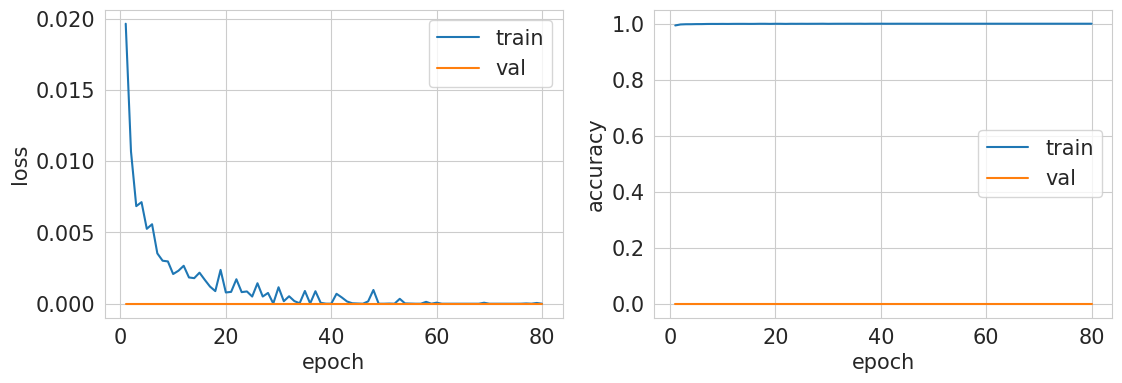

epoch 80, train_losses: 0.0000, val_losses: 0.0000, train_accuracies: 1.0000, val_accuracies: 0.0000, lr: 0.0


Predictions:   0%|          | 0/46 [00:00<?, ?it/s]

CPU times: user 14h 1min 38s, sys: 2h 57min 47s, total: 16h 59min 26s
Wall time: 16h 33min 27s


In [19]:
%%time

num_epochs = 80

model = get_model(
    model_name='efficientnet_v2_m', 
    weights=torchvision.models.EfficientNet_V2_M_Weights.DEFAULT,
)
model = model.to(device)

# В качестве cost function используем кросс-энтропию
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0)

optimizer = optim.AdamW(
    model.parameters(),
    # lr=3e-4,
    # lr=1e-4,
    lr=0.0001,
    # weight_decay=1e-3 
    weight_decay=2e-05
)

# scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs
)

#создаем словать из того что хотим сохранить
NAME = 'no_rotation_m_epoch_80_extra_full_dataset_val_0_lr_0001'
state = {
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': train_losses[-1],
    'accuracy': train_accuracies[-1]
}
torch.save(state, f'./checkpoints-v2/{NAME}.pth')

predictions_class, predictions_prob, logit, logits = model_inference(model, test_loader)
assert len(predictions_prob) == 506

SAVE_PATH = f'./submission-v2/{NAME}.csv'
test_df_with_predictions = test_df.copy()
test_df_with_predictions['id'] = test_df_with_predictions['id'].str.replace('./data/images/','')

test_df_with_predictions['target'] = predictions_prob
if os.path.exists(SAVE_PATH):
    os.remove(SAVE_PATH)
test_df_with_predictions.to_csv(SAVE_PATH, index=False)

2. 16К данных ( модель дала лучший скор на привает из всех вариантов экспериментов).
Тут график с val данными. Но как писала выше в сабмит отсылала уже обученную модель на всех данных (train + val)

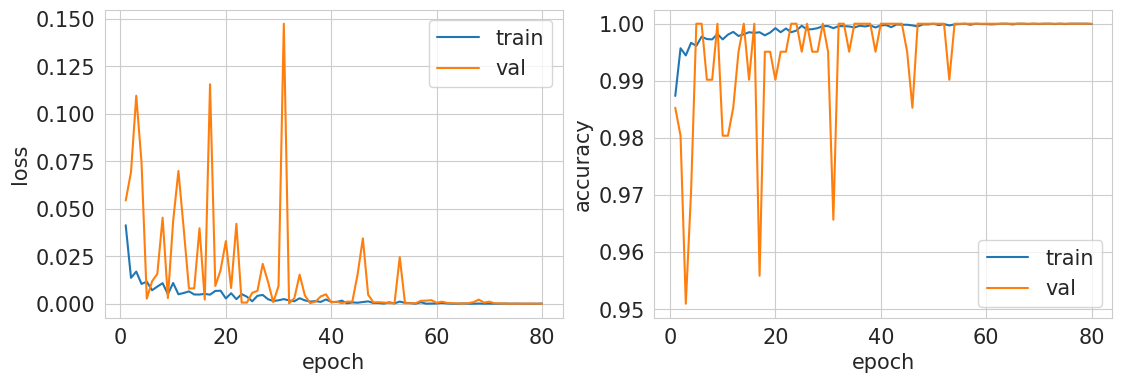

epoch 80, train_losses: 0.0001, val_losses: 0.0000, train_accuracies: 0.9999, val_accuracies: 1.0000, lr: 0.0


Predictions:   0%|          | 0/46 [00:00<?, ?it/s]

CPU times: user 6h 6min 24s, sys: 1h 20min 21s, total: 7h 26min 46s
Wall time: 7h 16min 44s


In [19]:
%%time

num_epochs = 80

model = get_model(
    model_name='efficientnet_v2_m', 
    weights=torchvision.models.EfficientNet_V2_M_Weights.DEFAULT,
)
model = model.to(device)

# В качестве cost function используем кросс-энтропию
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0)

optimizer = optim.AdamW(
    model.parameters(),
    # lr=3e-4,
    # lr=1e-4,
    lr=0.0001,
    # weight_decay=1e-3 
    weight_decay=2e-05
)

# scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs
)

#создаем словать из того что хотим сохранить
NAME = 'm_epoch_80_full_dataset_val_02_lr_0001'
state = {
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': train_losses[-1],
    'accuracy': train_accuracies[-1]
}
torch.save(state, f'./checkpoints-v2/{NAME}.pth')

predictions_class, predictions_prob, logit, logits = model_inference(model, test_loader)
assert len(predictions_prob) == 506

SAVE_PATH = f'./submission-v2/{NAME}.csv'
test_df_with_predictions = test_df.copy()
test_df_with_predictions['id'] = test_df_with_predictions['id'].str.replace('./data/images/','')

test_df_with_predictions['target'] = predictions_prob
if os.path.exists(SAVE_PATH):
    os.remove(SAVE_PATH)
test_df_with_predictions.to_csv(SAVE_PATH, index=False)

3. Обученная модель только на исходном датасете. Private Score = 0.0059, Public Score = 0.02049

кол-во эпох = 200 ( остальные параметры обучения те же что и для модели с большим кол-вом данных)

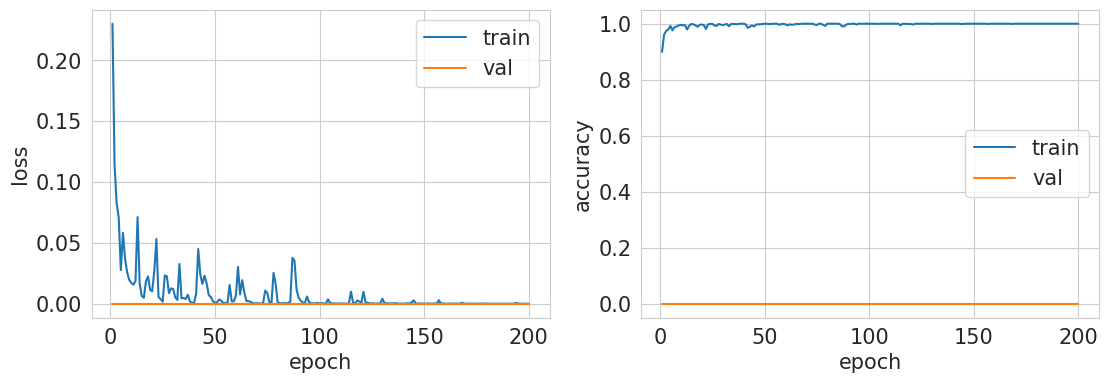

epoch 200, train_losses: 0.0000, val_losses: 0.0000, train_accuracies: 1.0000, val_accuracies: 0.0000, lr: 0.0


Predictions:   0%|          | 0/46 [00:00<?, ?it/s]

CPU times: user 54min 23s, sys: 11min 43s, total: 1h 6min 6s
Wall time: 1h 5min 7s


In [19]:
%%time

num_epochs = 200

model = get_model(
    model_name='efficientnet_v2_m', 
    weights=torchvision.models.EfficientNet_V2_M_Weights.DEFAULT,
)
model = model.to(device)

# # В качестве cost function используем кросс-энтропию
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0)

optimizer = optim.AdamW(
    model.parameters(),
    # lr=3e-4,
    # lr=1e-4,
    lr=0.0001,
    # weight_decay=1e-3 
    weight_decay=2e-05
)

# scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs
)

#создаем словать из того что хотим сохранить
NAME = 'm_epoch_200_original_dataset_val_0_lr_0001'
state = {
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': train_losses[-1],
    'accuracy': train_accuracies[-1]
}
torch.save(state, f'./checkpoints-v2/{NAME}.pth')

predictions_class, predictions_prob, logit, logits = model_inference(model, test_loader)
assert len(predictions_prob) == 506

SAVE_PATH = f'./submission-v2/{NAME}.csv'
test_df_with_predictions = test_df.copy()
test_df_with_predictions['id'] = test_df_with_predictions['id'].str.replace('./data/images/','')

test_df_with_predictions['target'] = predictions_prob
if os.path.exists(SAVE_PATH):
    os.remove(SAVE_PATH)
test_df_with_predictions.to_csv(SAVE_PATH, index=False)

Итог.
Досточно простая модель CNN справилась хорошо с задачей. Не увидела смысла обучать другие модели ( как например трансформеры). Часто простая модель и верно подобранные гиперпараметы и аугументации - дают уже хорошее качество и приемлемое время обучения.

Так же была идея попробовать обучить CLIP ( Разморозив только последний слой как вариант.) - Потому что при обучении zero-shot Clip показал - уже хорошие результаты.

Но так как результат CNN уже был удовлитвориетельным даже на исходном датасете и время обучения было адекватно- не стала эксперементировать с CLIP дальше.


In [7]:
# пример работы CLIP на одной из самой "плохой" картинке - где сеть в ходе экспериментов показывала неуверенные результаты . Тут можно заметитьь что CLIP в режиме всего лишь ZERO shot уже показывает верные результаты. 
# значит можно дофайтюнить ( напрмер разморозить последний слой) и улушить качеств. 
import clip

model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("./data/images/DuwXCNmeMx.webp")).unsqueeze(0).to(device)
text = clip.tokenize(["real", "fake" ]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    # DuwXCNmeMx
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  

Label probs: [[0.4226 0.5776]]
